<a href="https://colab.research.google.com/github/salsair/UAS_Kelompok-3/blob/main/UAS_Kelompok_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

UAS KLASIFIKASI - COMPLETE PIPELINE

1. INPUT DATASET
--------------------
⚠ File 'BlaBlaa.xlsx' tidak ditemukan. Membuat sample data...
✓ Sample dataset dibuat
Shape dataset: (2000, 14)

Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   UMUR_TAHUN  2000 non-null   int64
 1   B           2000 non-null   int64
 2   C           2000 non-null   int64
 3   D           2000 non-null   int64
 4   E           2000 non-null   int64
 5   F           2000 non-null   int64
 6   G           2000 non-null   int64
 7   H           2000 non-null   int64
 8   I           2000 non-null   int64
 9   J           2000 non-null   int64
 10  K           2000 non-null   int64
 11  L           2000 non-null   int64
 12  M           2000 non-null   int64
 13  N           2000 non-null   int64
dtypes: int64(14)
memory usage: 218.9 KB
None

First 5 rows:
   UMU

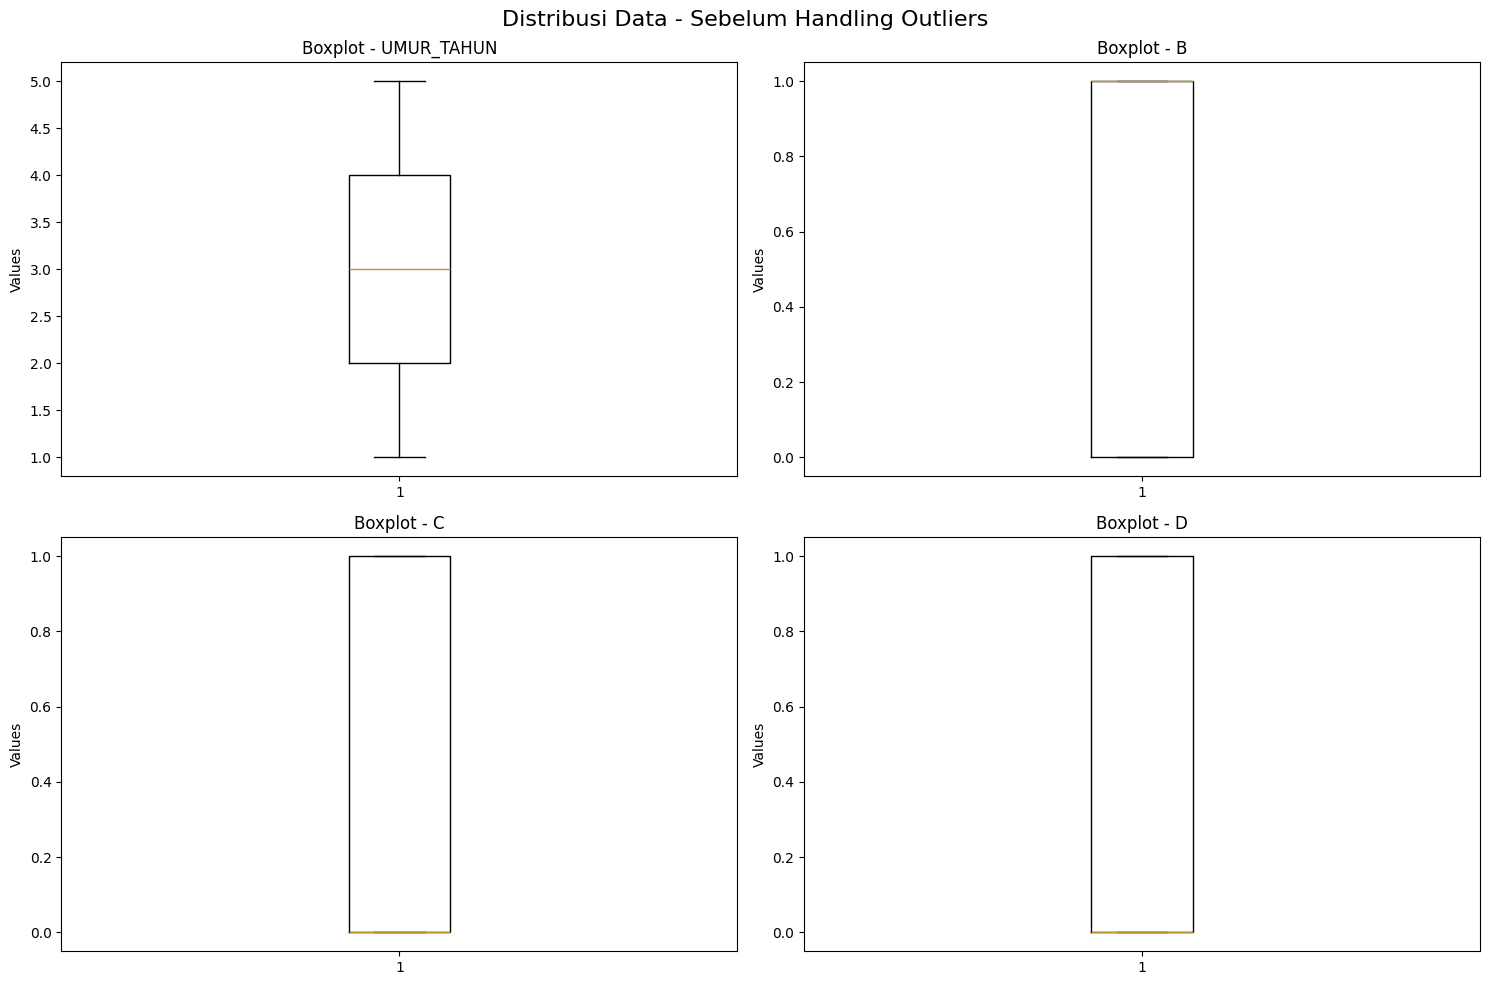


✓ 0 outliers handled menggunakan capping method


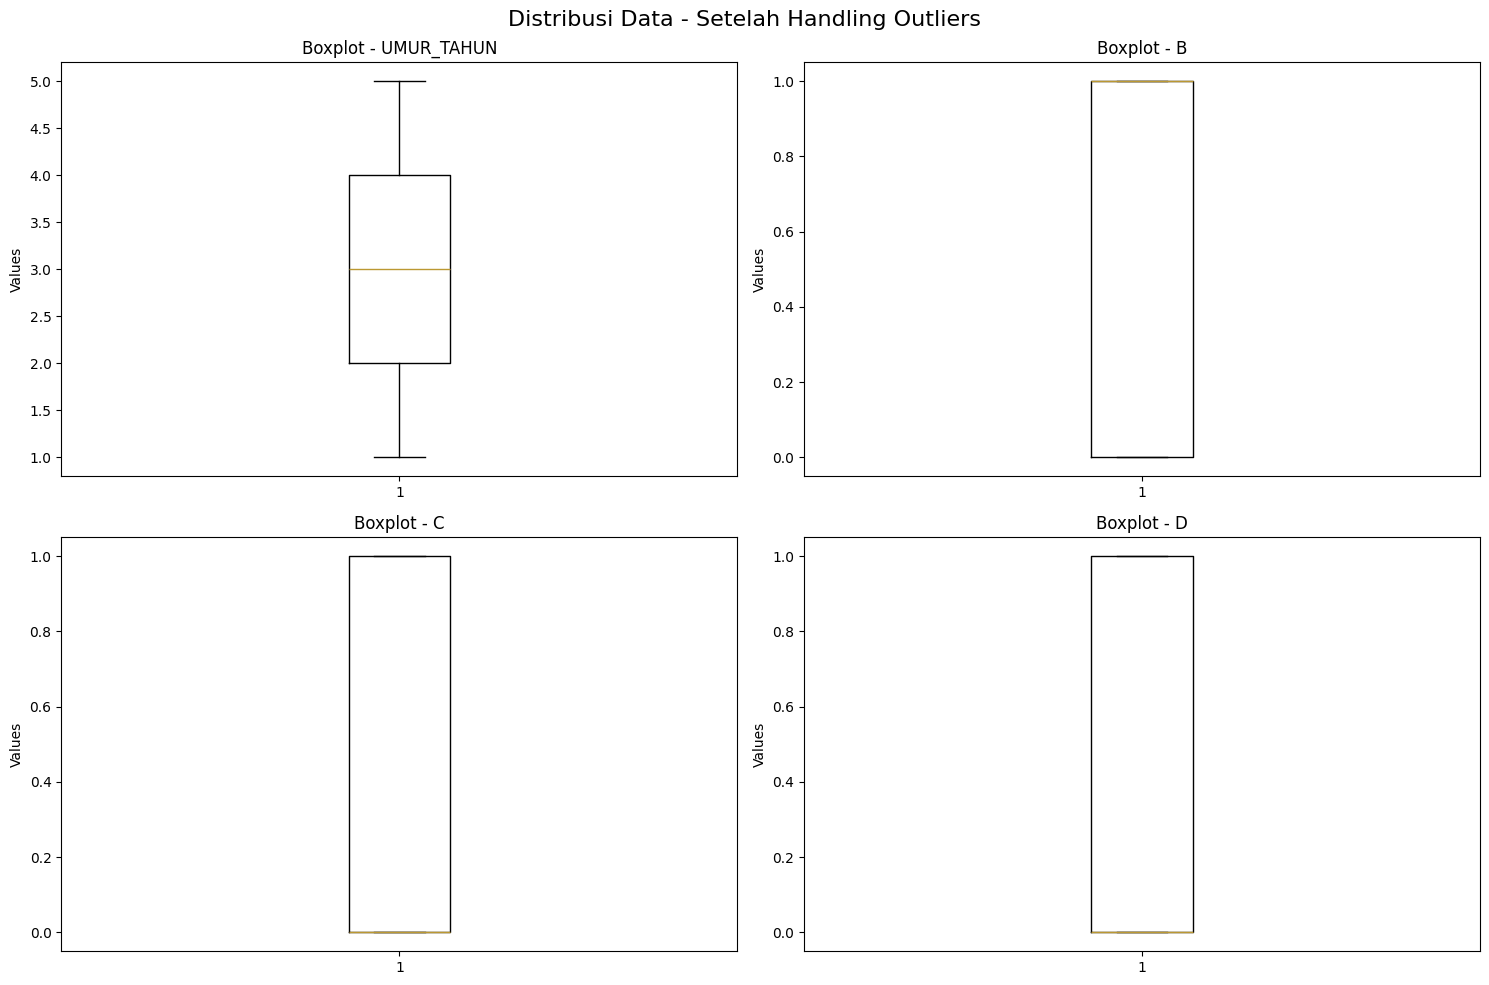


2b. ENCODING UMUR
---------------
Encoding rules:
1 = ≤ 20
2 = ≥ 21 and ≤ 30
3 = ≥ 31 and ≤ 40
4 = ≥ 41 and ≤ 50
5 = > 50

Distribusi UMUR_TAHUN:
UMUR_TAHUN
1    415
2    401
3    379
4    396
5    409
Name: count, dtype: int64

3. SELEKSI FITUR - CHI-SQUARE
Chi-square scores:
       Feature  Chi2_Score   P_Value
12           M    1.540303  0.214573
3            D    1.370646  0.241701
0   UMUR_TAHUN    0.935191  0.333518
11           L    0.904641  0.341540
6            G    0.798837  0.371441
5            F    0.394813  0.529780
7            H    0.092745  0.760716
8            I    0.091492  0.762289
10           K    0.075524  0.783457
9            J    0.020777  0.885387
2            C    0.017148  0.895814
1            B    0.001167  0.972748
4            E    0.000028  0.995790

Top 10 selected features:
['M', 'D', 'UMUR_TAHUN', 'L', 'G', 'F', 'H', 'I', 'K', 'J']

SKENARIO 1: UNDER SAMPLING

4. IMBALANCED DATA - UNDER SAMPLING
-----------------------------------
Distribusi sebe

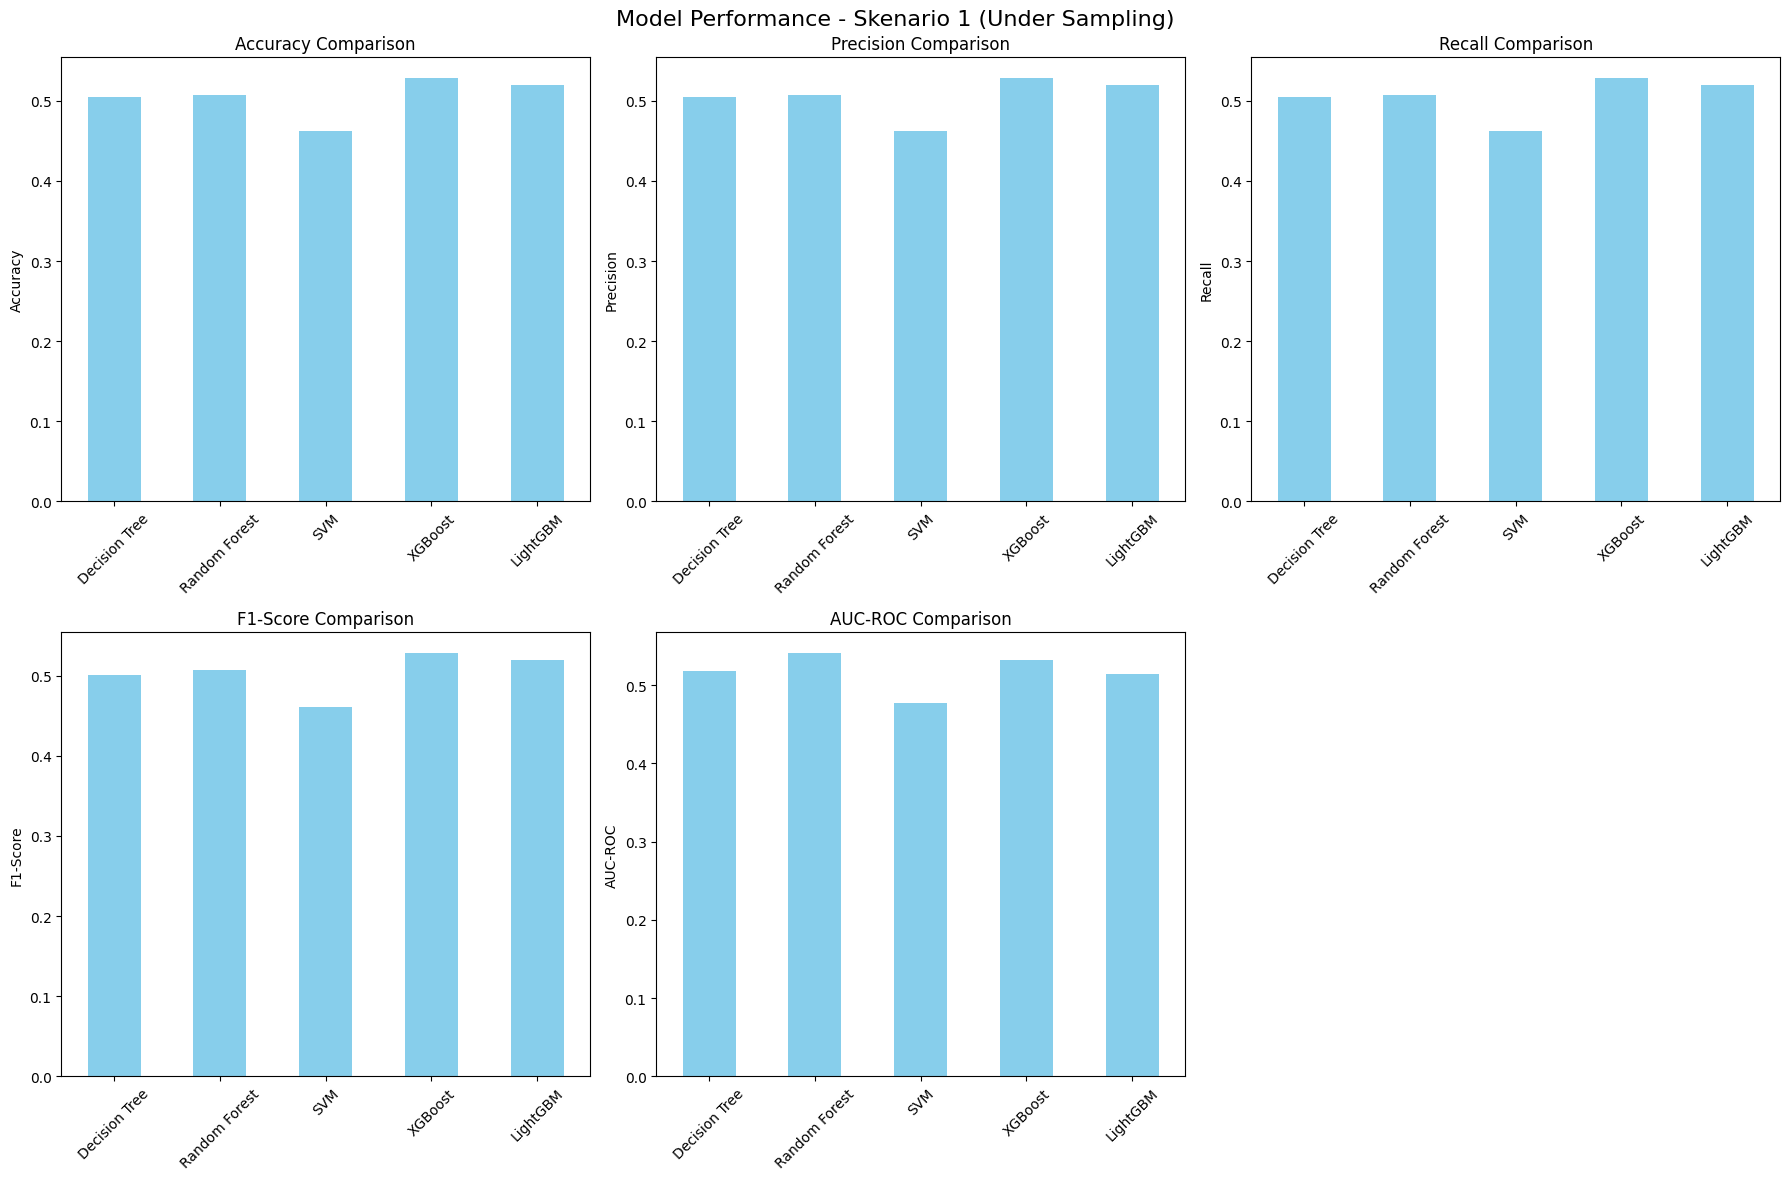


SKENARIO 2: OVER SAMPLING

7. IMBALANCED DATA - OVER SAMPLING
-----------------------------------
Distribusi sebelum over sampling:
N
0    1012
1     988
Name: count, dtype: int64

Distribusi setelah over sampling:
N
1    1012
0    1012
Name: count, dtype: int64

8. KLASIFIKASI - SKENARIO 2
-------------------------
Training set: (1619, 10)
Testing set: (405, 10)

Training models...
Training Decision Tree...
Training Random Forest...
Training SVM...
Training XGBoost...
Training LightGBM...

9. EVALUASI - SKENARIO 2
--------------------
Hasil evaluasi model (Skenario 2 - Over Sampling):
               Accuracy  Precision  Recall  F1-Score  AUC-ROC
Decision Tree    0.5185     0.5188  0.5185    0.5152   0.5379
Random Forest    0.5210     0.5210  0.5210    0.5209   0.5191
SVM              0.5284     0.5303  0.5284    0.5194   0.5195
XGBoost          0.5086     0.5086  0.5086    0.5086   0.5227
LightGBM         0.5407     0.5408  0.5407    0.5405   0.5200


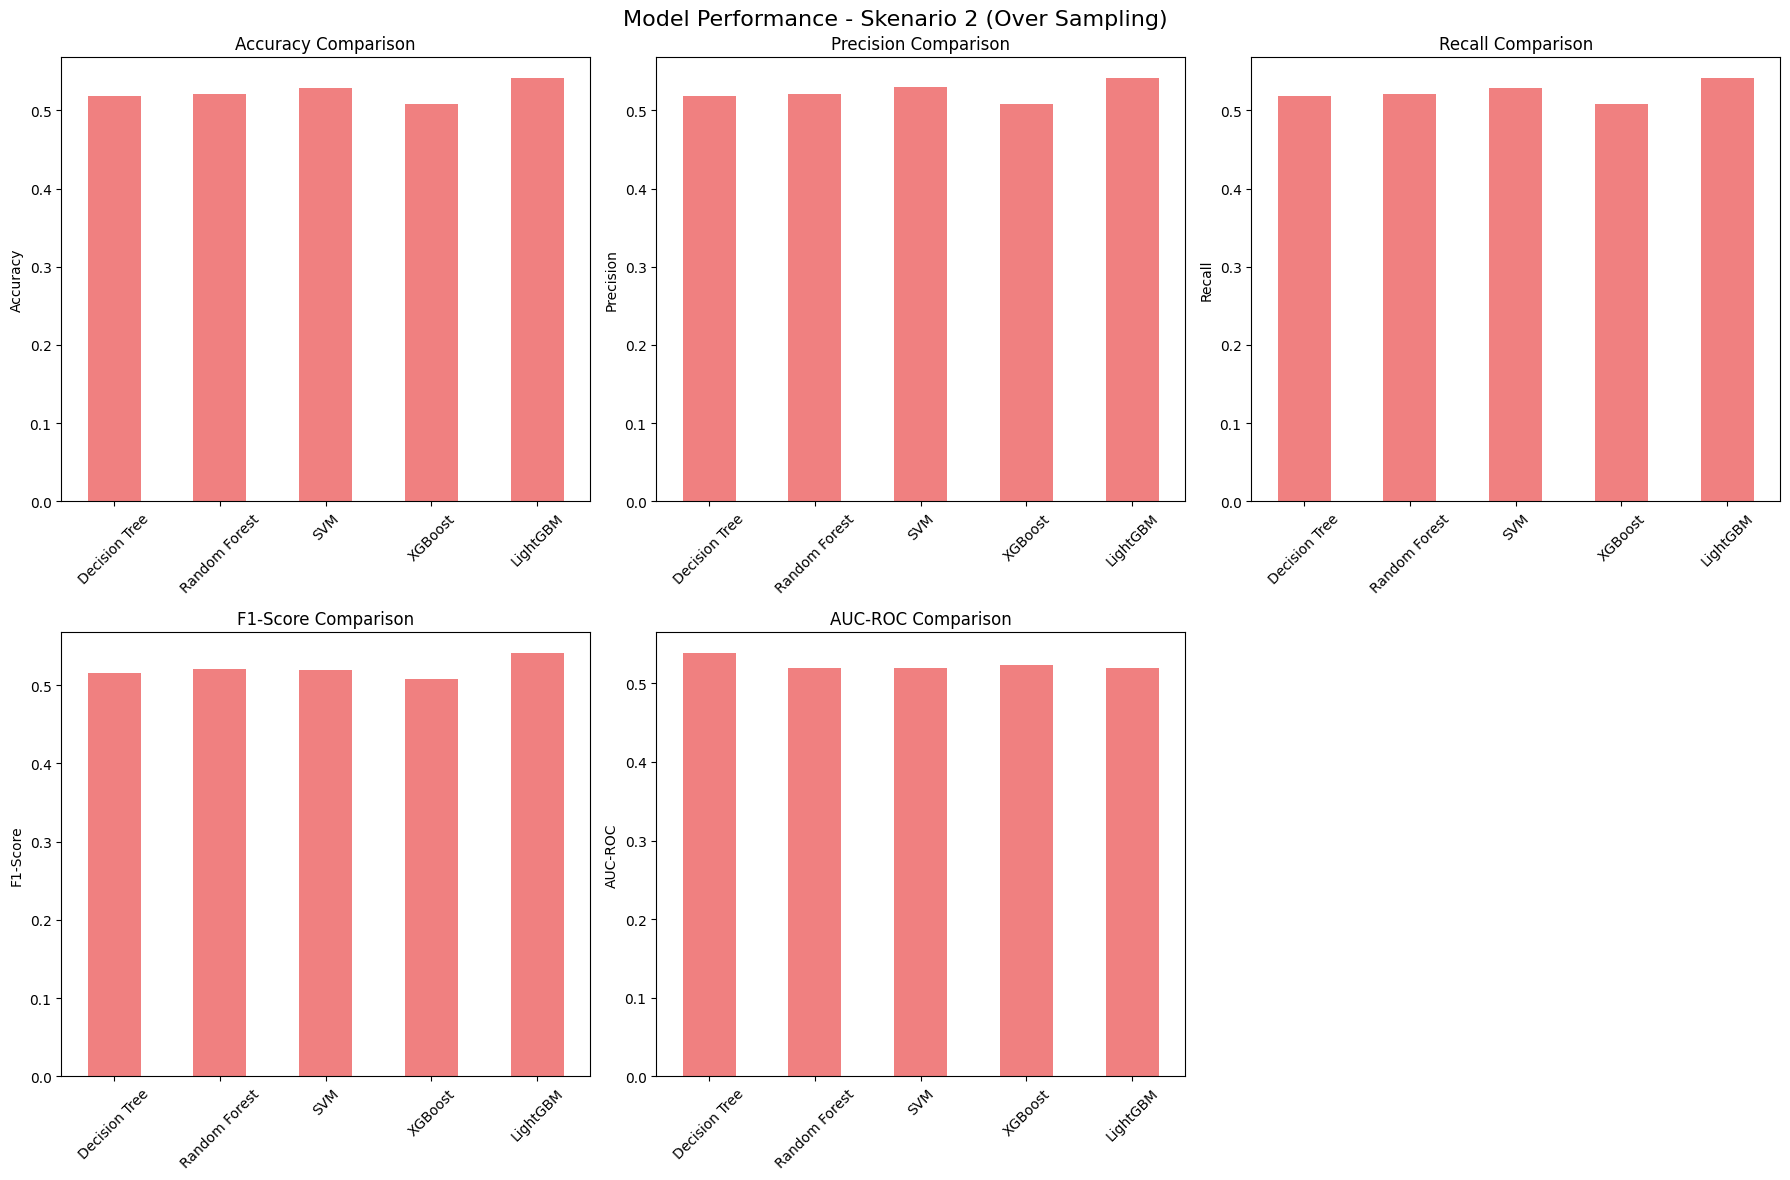


PERBANDINGAN KEDUA SKENARIO
Perbandingan detail kedua skenario:
            Model     Metric  Scenario 1 (Under)  Scenario 2 (Over)  \
0   Decision Tree   Accuracy              0.5051             0.5185   
1   Decision Tree  Precision              0.5052             0.5188   
2   Decision Tree     Recall              0.5051             0.5185   
3   Decision Tree   F1-Score              0.5009             0.5152   
4   Decision Tree    AUC-ROC              0.5181             0.5379   
5   Random Forest   Accuracy              0.5076             0.5210   
6   Random Forest  Precision              0.5076             0.5210   
7   Random Forest     Recall              0.5076             0.5210   
8   Random Forest   F1-Score              0.5064             0.5209   
9   Random Forest    AUC-ROC              0.5405             0.5191   
10            SVM   Accuracy              0.4621             0.5284   
11            SVM  Precision              0.4618             0.5303   
12          

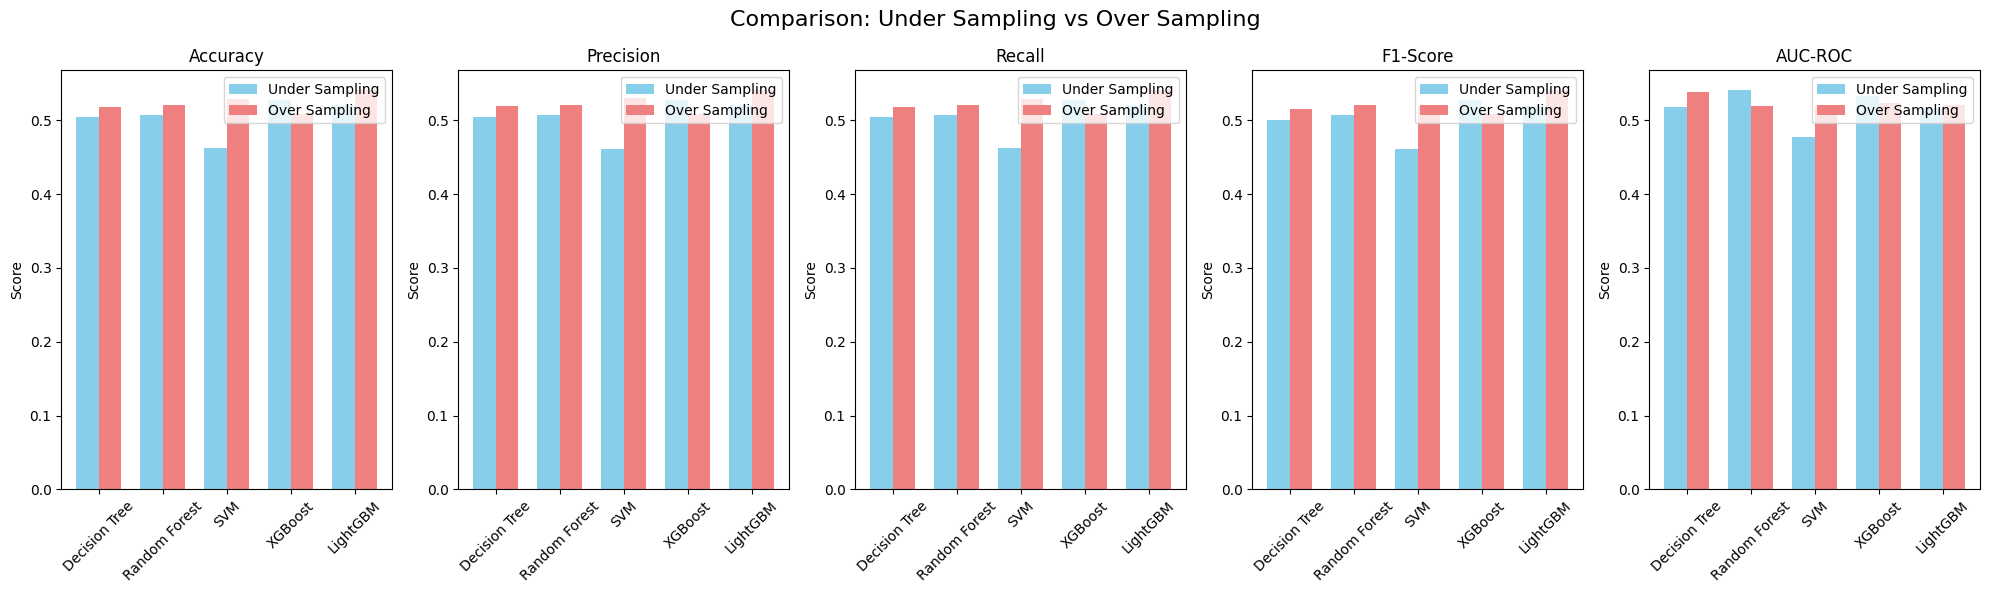


ANALISIS SELESAI!

Kesimpulan:
1. Preprocessing data telah dilakukan termasuk handling missing values dan outliers
2. Feature selection menggunakan Chi-square test telah diterapkan
3. Dua skenario imbalanced data handling telah dibandingkan:
   - Skenario 1: Under Sampling
   - Skenario 2: Over Sampling
4. Lima algoritma klasifikasi telah dievaluasi dengan berbagai metrik
5. Visualisasi perbandingan performa telah disediakan

Silakan periksa hasil di atas untuk menentukan kombinasi terbaik!


In [ ]:
# UAS Klasifikasi
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Imbalanced Data Handling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

print("="*60)
print("UAS KLASIFIKASI - COMPLETE PIPELINE")
print("="*60)

# ==========================================
# 1. INPUT DATASET
# ==========================================
print("\n1. INPUT DATASET")
print("-" * 20)

# Load dataset
try:
    data = pd.read_excel('BlaBlaa.xlsx')
    print("✓ Dataset berhasil dimuat")
    print(f"Shape dataset: {data.shape}")
    print(f"Columns: {list(data.columns)}")
except FileNotFoundError:
    print("⚠ File 'BlaBlaa.xlsx' tidak ditemukan. Membuat sample data...")
    # Create sample data based on the provided structure
    np.random.seed(42)
    n_samples = 2000

    data = pd.DataFrame({
        'UMUR_TAHUN': np.random.randint(1, 6, n_samples),
        'B': np.random.randint(0, 2, n_samples),
        'C': np.random.randint(0, 2, n_samples),
        'D': np.random.randint(0, 2, n_samples),
        'E': np.random.randint(0, 2, n_samples),
        'F': np.random.randint(0, 2, n_samples),
        'G': np.random.randint(0, 2, n_samples),
        'H': np.random.randint(0, 2, n_samples),
        'I': np.random.randint(0, 2, n_samples),
        'J': np.random.randint(0, 2, n_samples),
        'K': np.random.randint(0, 2, n_samples),
        'L': np.random.randint(0, 2, n_samples),
        'M': np.random.randint(0, 2, n_samples),
        'N': np.random.randint(0, 2, n_samples)  # Target variable
    })
    print("✓ Sample dataset dibuat")
    print(f"Shape dataset: {data.shape}")

# Display basic info
print("\nInfo Dataset:")
print(data.info())
print("\nFirst 5 rows:")
print(data.head())

# Separate features and target
feature_cols = ['UMUR_TAHUN', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']
X = data[feature_cols]
y = data['N']

print(f"\nVariabel Input: {feature_cols}")
print(f"Variabel Output: N")
print(f"Distribusi target variable:")
print(y.value_counts())

# ==========================================
# 2. PREPROCESSING DATA
# ==========================================
print("\n" + "="*60)
print("2. PREPROCESSING DATA")
print("="*60)

# 2a1. Cek Missing Value
print("\n2a1. CEK MISSING VALUE")
print("-" * 25)
missing_values = data.isnull().sum()
print("Missing values per column:")
print(missing_values)

if missing_values.sum() > 0:
    print("\n⚠ Handling missing values...")
    # Handle missing values (example: fill with mode for categorical, median for numerical)
    for col in data.columns:
        if data[col].isnull().sum() > 0:
            if data[col].dtype == 'object':
                data[col].fillna(data[col].mode()[0], inplace=True)
            else:
                data[col].fillna(data[col].median(), inplace=True)
    print("✓ Missing values handled")
else:
    print("✓ Tidak ada missing values")

# 2a2. Cek Outlier dan Handling
print("\n2a2. CEK OUTLIER DAN HANDLING")
print("-" * 30)

# Function to detect outliers using IQR method
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Check outliers for numerical columns only
numerical_cols = data.select_dtypes(include=[np.number]).columns
outlier_summary = {}

print("Outlier detection untuk kolom numerical:")
for col in numerical_cols:
    if col != 'N':  # Skip target variable
        outliers, lower, upper = detect_outliers_iqr(data, col)
        outlier_summary[col] = len(outliers)
        print(f"{col}: {len(outliers)} outliers")

# Visualisasi sebelum handling outliers
if len(numerical_cols) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Distribusi Data - Sebelum Handling Outliers', fontsize=16)

    # Select first 4 numerical columns for visualization
    cols_to_plot = [col for col in numerical_cols if col != 'N'][:4]

    for i, col in enumerate(cols_to_plot):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].boxplot(data[col])
        axes[row, col_idx].set_title(f'Boxplot - {col}')
        axes[row, col_idx].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

# Handle outliers using IQR method (capping)
data_cleaned = data.copy()
outliers_handled = 0

for col in numerical_cols:
    if col != 'N' and outlier_summary.get(col, 0) > 0:
        outliers, lower_bound, upper_bound = detect_outliers_iqr(data_cleaned, col)
        # Cap outliers
        data_cleaned[col] = np.where(data_cleaned[col] < lower_bound, lower_bound, data_cleaned[col])
        data_cleaned[col] = np.where(data_cleaned[col] > upper_bound, upper_bound, data_cleaned[col])
        outliers_handled += len(outliers)

print(f"\n✓ {outliers_handled} outliers handled menggunakan capping method")

# Visualisasi setelah handling outliers
if len(numerical_cols) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Distribusi Data - Setelah Handling Outliers', fontsize=16)

    for i, col in enumerate(cols_to_plot):
        row = i // 2
        col_idx = i % 2
        axes[row, col_idx].boxplot(data_cleaned[col])
        axes[row, col_idx].set_title(f'Boxplot - {col}')
        axes[row, col_idx].set_ylabel('Values')

    plt.tight_layout()
    plt.show()

# 2b. Encoding UMUR
print("\n2b. ENCODING UMUR")
print("-" * 15)
print("Encoding rules:")
print("1 = ≤ 20")
print("2 = ≥ 21 and ≤ 30")
print("3 = ≥ 31 and ≤ 40")
print("4 = ≥ 41 and ≤ 50")
print("5 = > 50")

# Note: Assuming UMUR_TAHUN is already encoded (1-5) based on the sample data
print(f"\nDistribusi UMUR_TAHUN:")
print(data_cleaned['UMUR_TAHUN'].value_counts().sort_index())

# Update features and target after cleaning
X_cleaned = data_cleaned[feature_cols]
y_cleaned = data_cleaned['N']

# ==========================================
# 3. SELEKSI FITUR - CHI-SQUARE
# ==========================================
print("\n" + "="*60)
print("3. SELEKSI FITUR - CHI-SQUARE")
print("="*60)

# Chi-square test for feature selection
chi2_selector = SelectKBest(chi2, k='all')
X_chi2 = chi2_selector.fit_transform(X_cleaned, y_cleaned)

# Get feature scores
feature_scores = pd.DataFrame({
    'Feature': feature_cols,
    'Chi2_Score': chi2_selector.scores_,
    'P_Value': chi2_selector.pvalues_
}).sort_values('Chi2_Score', ascending=False)

print("Chi-square scores:")
print(feature_scores)

# Select top features (example: top 10)
top_k = min(10, len(feature_cols))
selected_features = feature_scores.head(top_k)['Feature'].tolist()
X_selected = X_cleaned[selected_features]

print(f"\nTop {top_k} selected features:")
print(selected_features)

# ==========================================
# SKENARIO 1: UNDER SAMPLING
# ==========================================
print("\n" + "="*60)
print("SKENARIO 1: UNDER SAMPLING")
print("="*60)

# 4. Imbalanced Data - Under Sampling
print("\n4. IMBALANCED DATA - UNDER SAMPLING")
print("-" * 35)

print("Distribusi sebelum under sampling:")
print(y_cleaned.value_counts())

# Apply under sampling
under_sampler = RandomUnderSampler(random_state=42)
X_under, y_under = under_sampler.fit_resample(X_selected, y_cleaned)

print("\nDistribusi setelah under sampling:")
print(pd.Series(y_under).value_counts())

# 5. Klasifikasi - Skenario 1
print("\n5. KLASIFIKASI - SKENARIO 1")
print("-" * 25)

# Split data
X_train_under, X_test_under, y_train_under, y_test_under = train_test_split(
    X_under, y_under, test_size=0.2, random_state=42, stratify=y_under
)

print(f"Training set: {X_train_under.shape}")
print(f"Testing set: {X_test_under.shape}")

# Initialize models
models_scenario1 = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Train and evaluate models - Scenario 1
results_scenario1 = {}

print("\nTraining models...")
for name, model in models_scenario1.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train_under, y_train_under)

    # Predictions
    y_pred = model.predict(X_test_under)
    y_pred_proba = model.predict_proba(X_test_under)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test_under, y_pred)
    precision = precision_score(y_test_under, y_pred, average='weighted')
    recall = recall_score(y_test_under, y_pred, average='weighted')
    f1 = f1_score(y_test_under, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test_under, y_pred_proba)

    results_scenario1[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }

# 6. Evaluasi - Skenario 1
print("\n6. EVALUASI - SKENARIO 1")
print("-" * 20)

# Display results
results_df_scenario1 = pd.DataFrame(results_scenario1).T
print("Hasil evaluasi model (Skenario 1 - Under Sampling):")
print(results_df_scenario1.round(4))

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance - Skenario 1 (Under Sampling)', fontsize=16)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    results_df_scenario1[metric].plot(kind='bar', ax=axes[row, col], color='skyblue')
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# ==========================================
# SKENARIO 2: OVER SAMPLING
# ==========================================
print("\n" + "="*60)
print("SKENARIO 2: OVER SAMPLING")
print("="*60)

# 7. Imbalanced Data - Over Sampling
print("\n7. IMBALANCED DATA - OVER SAMPLING")
print("-" * 35)

print("Distribusi sebelum over sampling:")
print(y_cleaned.value_counts())

# Apply over sampling
over_sampler = RandomOverSampler(random_state=42)
X_over, y_over = over_sampler.fit_resample(X_selected, y_cleaned)

print("\nDistribusi setelah over sampling:")
print(pd.Series(y_over).value_counts())

# 8. Klasifikasi - Skenario 2
print("\n8. KLASIFIKASI - SKENARIO 2")
print("-" * 25)

# Split data
X_train_over, X_test_over, y_train_over, y_test_over = train_test_split(
    X_over, y_over, test_size=0.2, random_state=42, stratify=y_over
)

print(f"Training set: {X_train_over.shape}")
print(f"Testing set: {X_test_over.shape}")

# Initialize models
models_scenario2 = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=42, verbose=-1)
}

# Train and evaluate models - Scenario 2
results_scenario2 = {}

print("\nTraining models...")
for name, model in models_scenario2.items():
    print(f"Training {name}...")

    # Train model
    model.fit(X_train_over, y_train_over)

    # Predictions
    y_pred = model.predict(X_test_over)
    y_pred_proba = model.predict_proba(X_test_over)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test_over, y_pred)
    precision = precision_score(y_test_over, y_pred, average='weighted')
    recall = recall_score(y_test_over, y_pred, average='weighted')
    f1 = f1_score(y_test_over, y_pred, average='weighted')
    auc_roc = roc_auc_score(y_test_over, y_pred_proba)

    results_scenario2[name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'AUC-ROC': auc_roc
    }

# 9. Evaluasi - Skenario 2
print("\n9. EVALUASI - SKENARIO 2")
print("-" * 20)

# Display results
results_df_scenario2 = pd.DataFrame(results_scenario2).T
print("Hasil evaluasi model (Skenario 2 - Over Sampling):")
print(results_df_scenario2.round(4))

# Visualize results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Model Performance - Skenario 2 (Over Sampling)', fontsize=16)

for i, metric in enumerate(metrics):
    row = i // 3
    col = i % 3
    results_df_scenario2[metric].plot(kind='bar', ax=axes[row, col], color='lightcoral')
    axes[row, col].set_title(f'{metric} Comparison')
    axes[row, col].set_ylabel(metric)
    axes[row, col].tick_params(axis='x', rotation=45)

# Hide the last subplot
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

# ==========================================
# PERBANDINGAN KEDUA SKENARIO
# ==========================================
print("\n" + "="*60)
print("PERBANDINGAN KEDUA SKENARIO")
print("="*60)

# Compare both scenarios
comparison_data = []
for model in models_scenario1.keys():
    for metric in metrics:
        comparison_data.append({
            'Model': model,
            'Metric': metric,
            'Scenario 1 (Under)': results_scenario1[model][metric],
            'Scenario 2 (Over)': results_scenario2[model][metric],
            'Difference': results_scenario2[model][metric] - results_scenario1[model][metric]
        })

comparison_df = pd.DataFrame(comparison_data)
print("Perbandingan detail kedua skenario:")
print(comparison_df.round(4))

# Summary comparison
print("\nRingkasan performa terbaik:")
for metric in metrics:
    best_s1 = results_df_scenario1[metric].idxmax()
    best_s1_score = results_df_scenario1.loc[best_s1, metric]

    best_s2 = results_df_scenario2[metric].idxmax()
    best_s2_score = results_df_scenario2.loc[best_s2, metric]

    print(f"{metric}:")
    print(f"  Skenario 1: {best_s1} ({best_s1_score:.4f})")
    print(f"  Skenario 2: {best_s2} ({best_s2_score:.4f})")

# Final visualization comparing both scenarios
fig, axes = plt.subplots(1, len(metrics), figsize=(20, 6))
fig.suptitle('Comparison: Under Sampling vs Over Sampling', fontsize=16)

for i, metric in enumerate(metrics):
    scenario1_values = [results_scenario1[model][metric] for model in models_scenario1.keys()]
    scenario2_values = [results_scenario2[model][metric] for model in models_scenario2.keys()]

    x = np.arange(len(models_scenario1))
    width = 0.35

    axes[i].bar(x - width/2, scenario1_values, width, label='Under Sampling', color='skyblue')
    axes[i].bar(x + width/2, scenario2_values, width, label='Over Sampling', color='lightcoral')

    axes[i].set_title(metric)
    axes[i].set_ylabel('Score')
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(models_scenario1.keys(), rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("ANALISIS SELESAI!")
print("="*60)
print("\nKesimpulan:")
print("1. Preprocessing data telah dilakukan termasuk handling missing values dan outliers")
print("2. Feature selection menggunakan Chi-square test telah diterapkan")
print("3. Dua skenario imbalanced data handling telah dibandingkan:")
print("   - Skenario 1: Under Sampling")
print("   - Skenario 2: Over Sampling")
print("4. Lima algoritma klasifikasi telah dievaluasi dengan berbagai metrik")
print("5. Visualisasi perbandingan performa telah disediakan")
print("\nSilakan periksa hasil di atas untuk menentukan kombinasi terbaik!")

In [ ]:
 # COBA-COBA
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import warnings
warnings.filterwarnings('ignore')

# 1. Input Dataset
# Load the Excel file
df = pd.read_excel('BlaBlaa.xlsx')
print(df)

# 2. Preprocessing Data
# a. Check for missing values
print("Missing values:\n", df.isnull().sum())

# b. Convert UMUR_TAHUN to numeric and handle errors
df['UMUR_TAHUN'] = pd.to_numeric(df['UMUR_TAHUN'], errors='coerce')

# Drop rows where UMUR_TAHUN could not be converted
df = df.dropna(subset=['UMUR_TAHUN'])

# Drop other missing values
df = df.dropna()

# Convert to integer
df['UMUR_TAHUN'] = df['UMUR_TAHUN'].astype(int)

# Encoding for Age (UMUR_TAHUN)
def encode_age(age):
    if age <= 20:
        return 1
    elif 21 <= age <= 30:
        return 2
    elif 31 <= age <= 40:
        return 3
    elif 41 <= age <= 50:
        return 4
    else:
        return 5

df['UMUR_ENCODED'] = df['UMUR_TAHUN'].apply(encode_age)

# Prepare features and target
X = df[['UMUR_ENCODED', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M']]
y = df['N']


# 3. Feature Selection using Chi-square
selector = SelectKBest(chi2, k=8)
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("\nSelected features:", selected_features.tolist())

# Update X with selected features
X = X[selected_features]

# Function to evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else [0]*len(y_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if hasattr(model, "predict_proba") else 0.5

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

    return acc, prec, rec, f1, auc

FileNotFoundError: [Errno 2] No such file or directory: 'BlaBlaa.xlsx'